# Semantic segmentation of aerial imagery using U-Net

By employing a U-Net architecture and patchifying aerial images into **256x256x3** tensors, the model achieved notable performance, demonstrating a **test accuracy of 87%**, a Jaccard coefficient of 0.7308, and a loss of 0.8974. These results suggest strong generalization ability, as the model also exhibited a **validation accuracy of 84%**, a validation Jaccard coefficient of 0.6869, and a validation loss of 0.9149. These metrics indicate the model's proficiency in segmenting aerial imagery, effectively classifying pixels into distinct object categories. 

*     Building: #3C1098
*     Land (unpaved area): #8429F6
*     Road: #6EC1E4
*     Vegetation: #FEDD3A
*     Water: #E2A929
*     Unlabeled: #9B9B9B

It's essential to enable GPU acceleration within the Kaggle notebook environment. This is achieved by navigating to the right-side panel of the notebook and selecting "Session options"  Within the Session options, choose "GPU T4 x2" as the ACCELERATOR. 
For more informations refer [enable GPU T4 x2 as the ACCELERATOR](https://www.kaggle.com/docs/notebooks#settings) 

In [1]:
%pip install tensorflow
%pip install setuptools


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow version: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available.


In [3]:
%pip install matplotlib
%pip install scikit-learn
%pip install -U segmentation-models
%pip install patchify
%pip install Pillow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [6]:
root_directory = "/kaggle/input/semantic-segmentation/Semantic segmentation dataset/"

scaler = MinMaxScaler()
patch_size = 256

In [7]:

image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = sorted(os.listdir(path)) 
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   

                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)

                
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)

Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
Now patchifying image: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/images/image_part_008.jpg
Now patchifying image: /

In [8]:

mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        masks = sorted(os.listdir(path)) 
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):  

                mask = cv2.imread(path+"/"+mask_name, 1) 
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
                mask = np.array(mask)

                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] 
                        mask_dataset.append(single_patch_mask)


Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_002.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_003.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_004.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_005.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_006.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_007.png
Now patchifying mask: /kaggle/input/semantic-segmentation/Semantic segmentation dataset/Tile 7/masks/image_part_008.png
Now patchifying mask: /kaggle/input/sema

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

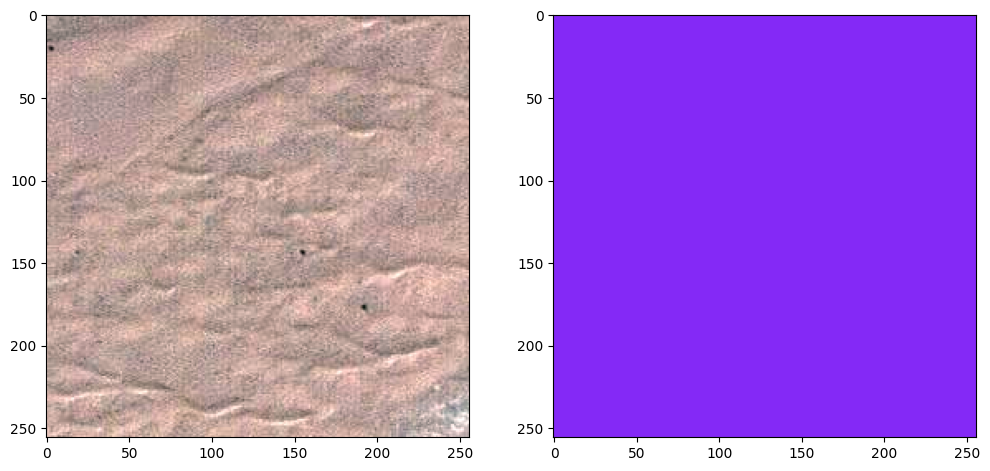

In [10]:

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [11]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [12]:

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0] 

    return label_seg

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


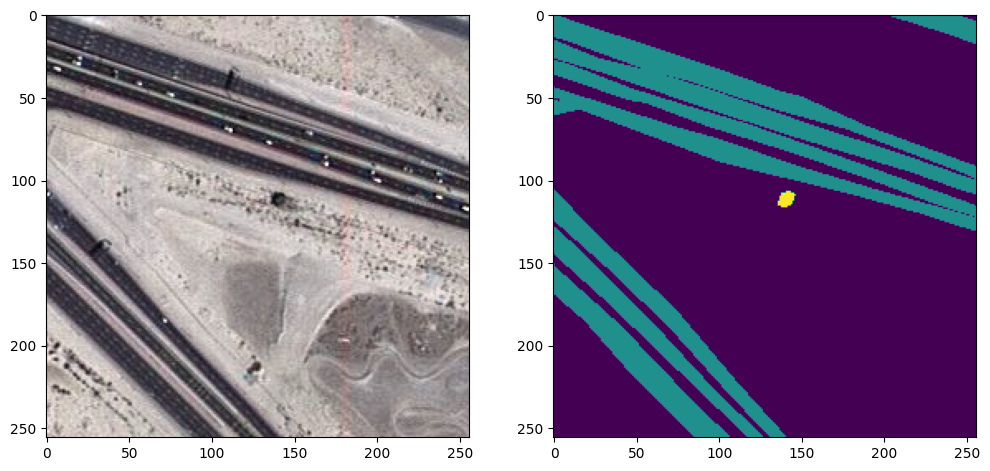

In [14]:

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [15]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [16]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [19]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

In [20]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [21]:
metrics=['accuracy', jacard_coef]

In [22]:
def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [23]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Set a specific convolution algorithm
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.force_gpu_compatible = True
session = tf.compat.v1.Session(config=config)


In [25]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Set the global policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify the policy
print(f'Mixed precision policy: {tf.keras.mixed_precision.global_policy()}')


Mixed precision policy: <FloatDTypePolicy "mixed_float16">


In [26]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [27]:

history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50


I0000 00:00:1724654327.366344     110 service.cc:145] XLA service 0x7ef8f8026e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724654327.366406     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724654327.366412     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/66 ━━━━━━━━━━━━━━━━━━━━ 38:06 35s/step - accuracy: 0.0676 - jacard_coef: 0.0661 - loss: 1.0666

I0000 00:00:1724654356.397426     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 543ms/step - accuracy: 0.4633 - jacard_coef: 0.2233 - loss: 1.0093 - val_accuracy: 0.6688 - val_jacard_coef: 0.3921 - val_loss: 0.9770
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.6819 - jacard_coef: 0.4190 - loss: 0.9704 - val_accuracy: 0.7252 - val_jacard_coef: 0.4867 - val_loss: 0.9591
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.7305 - jacard_coef: 0.4794 - loss: 0.9565 - val_accuracy: 0.7721 - val_jacard_coef: 0.5514 - val_loss: 0.9437
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.7753 - jacard_coef: 0.5423 - loss: 0.9433 - val_accuracy: 0.7981 - val_jacard_coef: 0.6053 - val_loss: 0.9316
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.7986 - jacard_coef: 0.5906 - loss: 0.9344 - val_accuracy: 0.8019 - val_jacard_coef: 0.6201 - val_loss: 0.9290
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.8114 - jacard_coef: 0.6171 - loss: 0.9281 - val_accuracy: 0.8093

In [28]:
model.save("/kaggle/working/satellite_standard_unet_100epochs.hdf5")

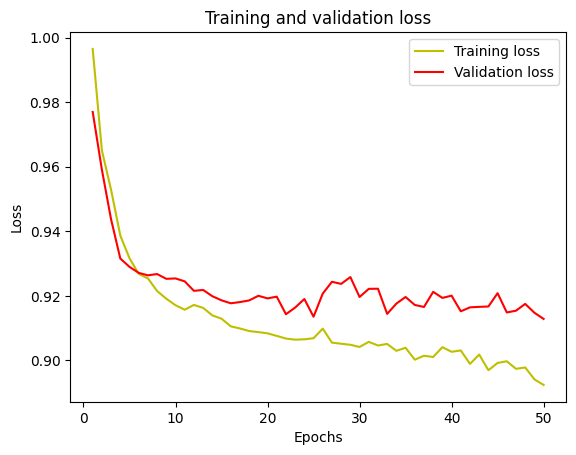

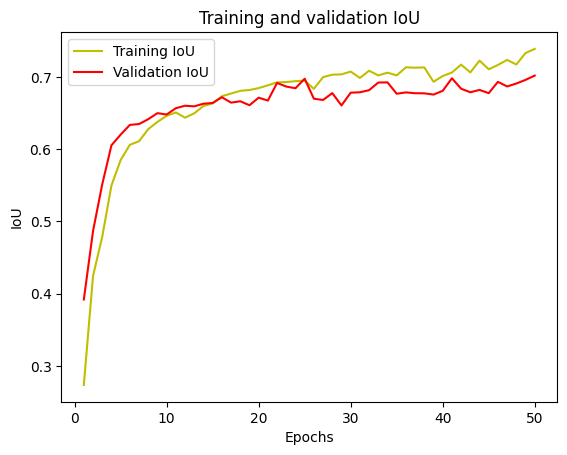

In [29]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [30]:
import tensorflow as tf

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow.keras.models import load_model
import segmentation_models as sm
from tensorflow.keras import backend as K

In [31]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

In [32]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [33]:

model_path = "/kaggle/working/satellite_standard_unet_100epochs.hdf5"

In [34]:
custom_objects = {
    "dice_loss_plus_1focal_loss": total_loss,
    "jacard_coef": jacard_coef
}


model = load_model(model_path, custom_objects=custom_objects)

In [35]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step


In [36]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.57392955


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


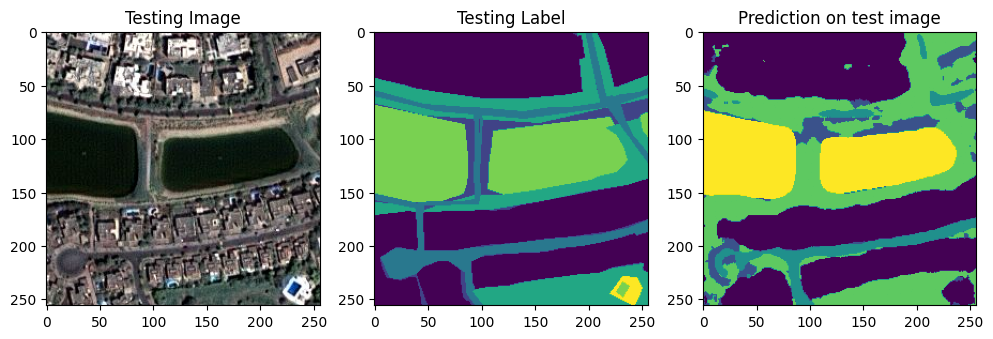

In [37]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 2000x2000 with 0 Axes>

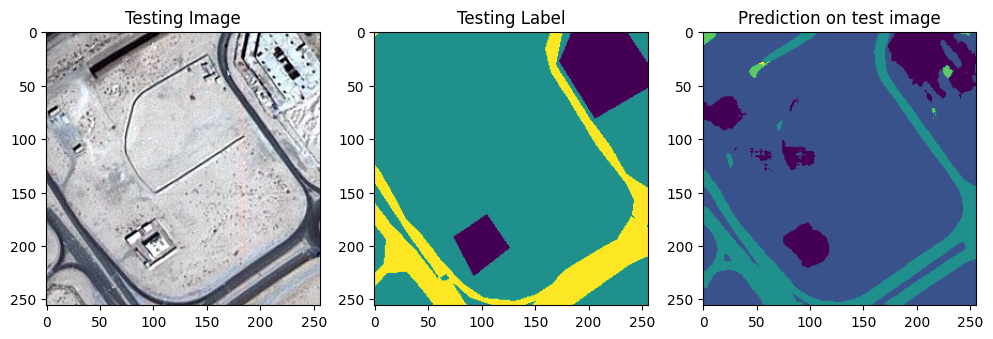

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


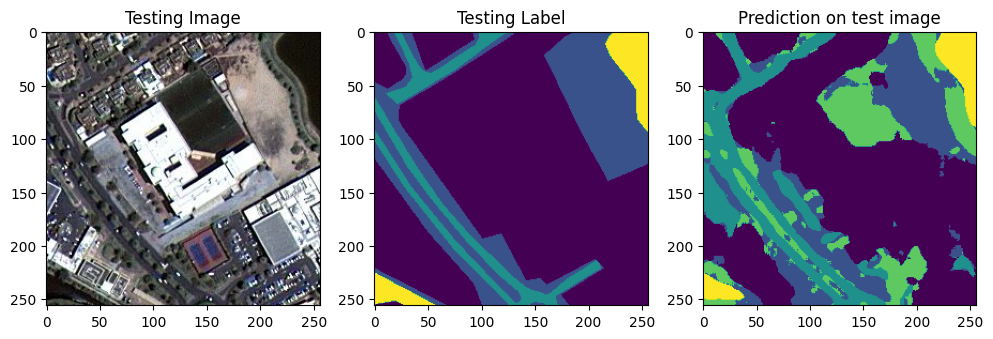

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


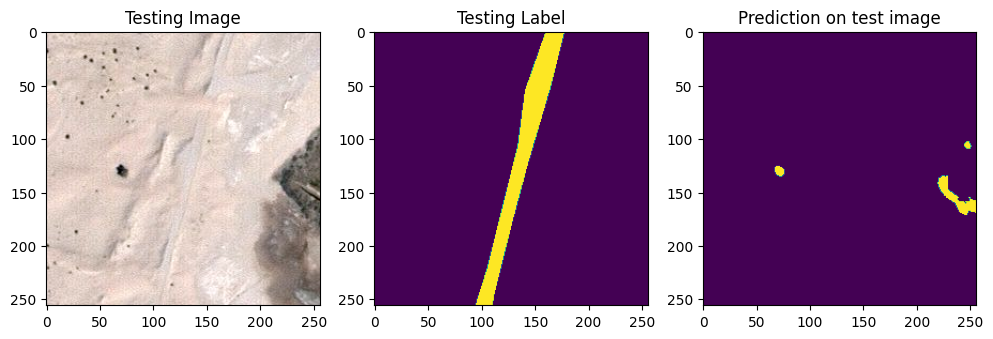

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


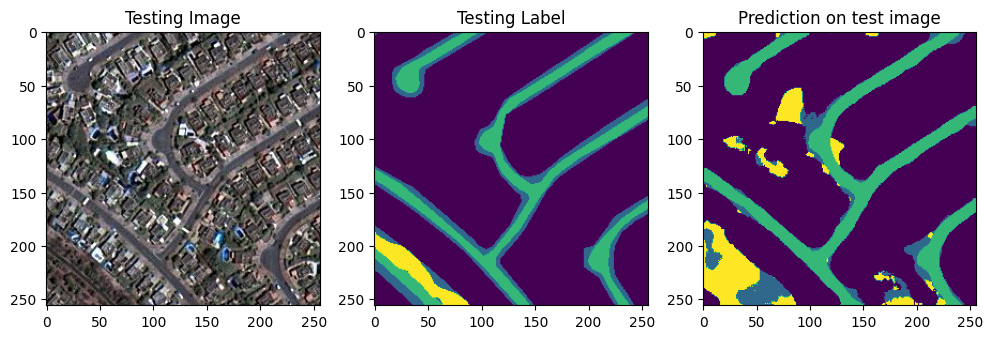

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


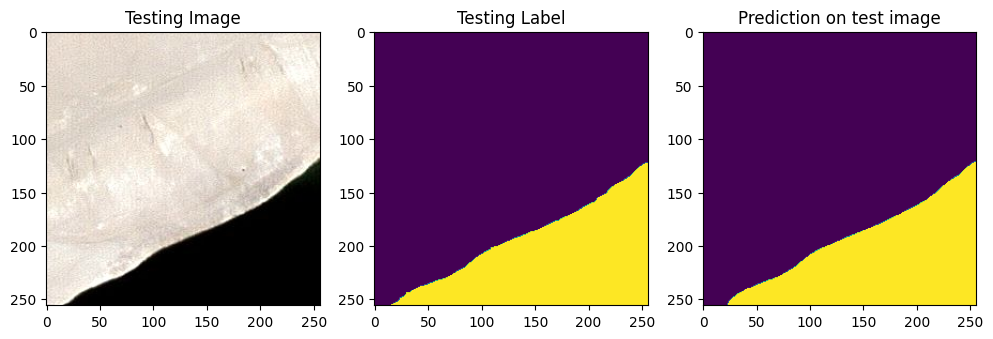

In [38]:
# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

In [39]:
import cv2
import numpy as np
from shapely.geometry import Polygon, mapping
import geojson

def segmented_image_to_geojson(segmented_image, mask_value=255):
    """
    Convert a segmented image into GeoJSON format.
    
    :param segmented_image: numpy array, segmented image where regions of interest are marked.
    :param mask_value: int, pixel value of the mask representing the regions of interest (default is 255).
    :return: GeoJSON object representing the segmented regions.
    """
    # Convert image to binary based on mask value
    binary_mask = (segmented_image == mask_value).astype(np.uint8)
    
    # Debug: Show the binary mask
    print("Binary mask:")
    plt.imshow(binary_mask, cmap='gray')
    plt.show()
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours found: {len(contours)}")
    
    features = []
    
    for contour in contours:
        if contour.size >= 3:  # Ensure contour is a valid polygon with at least 3 points
            polygon = Polygon(contour.reshape(-1, 2))
            feature = geojson.Feature(geometry=mapping(polygon), properties={})
            features.append(feature)
    
    feature_collection = geojson.FeatureCollection(features)
    
    return feature_collection


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 2000x2000 with 0 Axes>

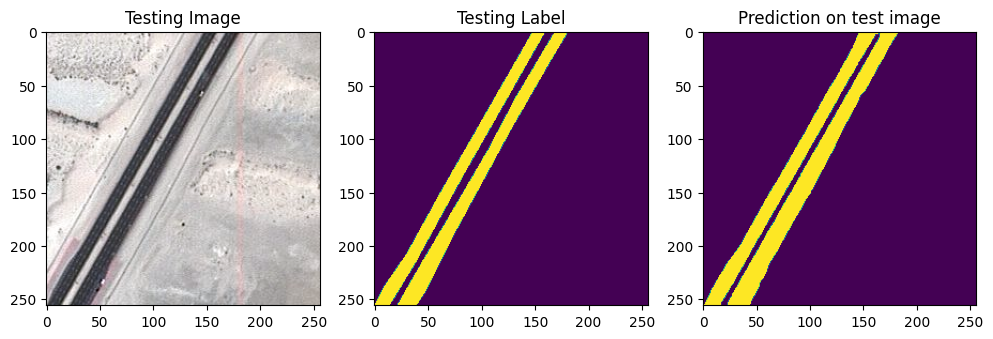

GeoJSON for predicted image 0:
{
  "type": "FeatureCollection",
  "features": []
}
GeoJSON for predicted image 0 saved as predicted_image_0.geojson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


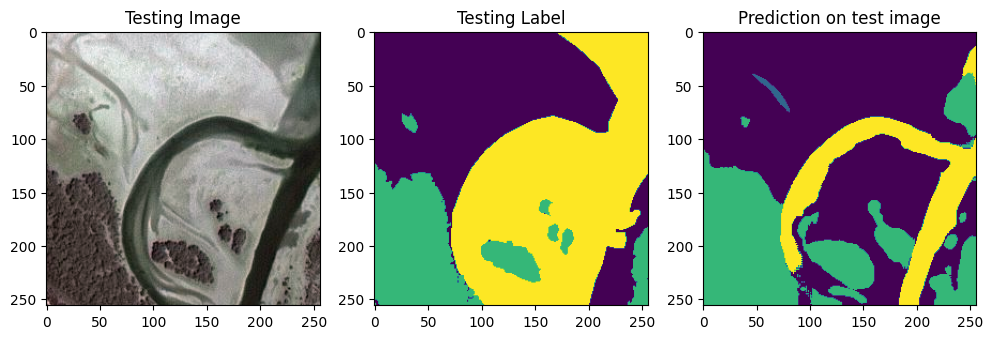

GeoJSON for predicted image 1:
{
  "type": "FeatureCollection",
  "features": []
}
GeoJSON for predicted image 1 saved as predicted_image_1.geojson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


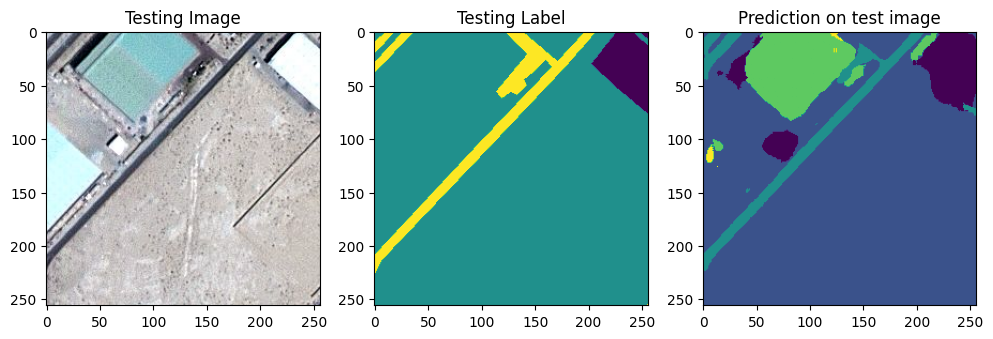

GeoJSON for predicted image 2:
{
  "type": "FeatureCollection",
  "features": []
}
GeoJSON for predicted image 2 saved as predicted_image_2.geojson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


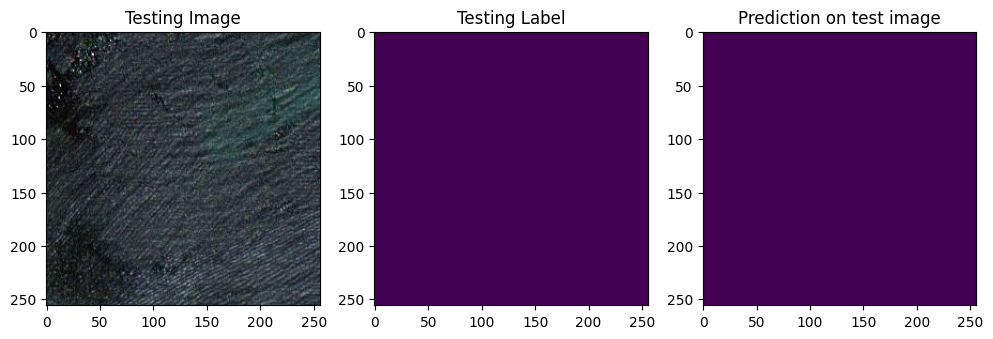

GeoJSON for predicted image 3:
{
  "type": "FeatureCollection",
  "features": []
}
GeoJSON for predicted image 3 saved as predicted_image_3.geojson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


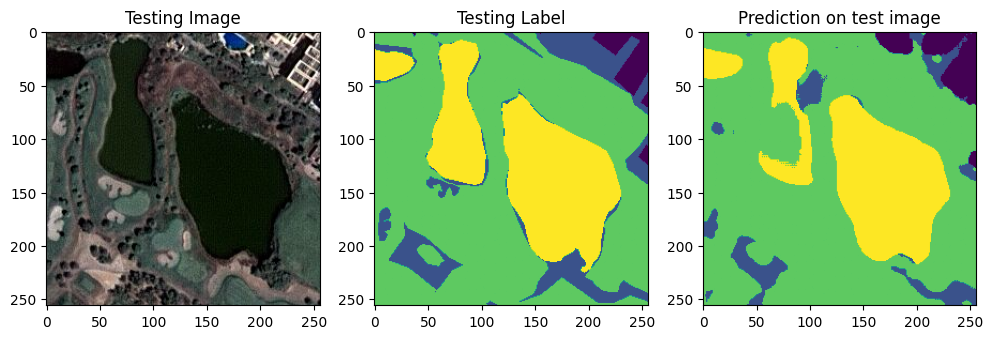

GeoJSON for predicted image 4:
{
  "type": "FeatureCollection",
  "features": []
}
GeoJSON for predicted image 4 saved as predicted_image_4.geojson


In [40]:
import cv2
import numpy as np
from shapely.geometry import Polygon, mapping
import geojson
import random
import matplotlib.pyplot as plt

def segmented_image_to_geojson(segmented_image, mask_value=255):
    """
    Convert a segmented image into GeoJSON format.
    
    :param segmented_image: numpy array, segmented image where regions of interest are marked.
    :param mask_value: int, pixel value of the mask representing the regions of interest (default is 255).
    :return: GeoJSON object representing the segmented regions.
    """
    contours, _ = cv2.findContours((segmented_image == mask_value).astype(np.uint8),
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features = []
    
    for contour in contours:
        polygon = Polygon(contour.reshape(-1, 2))
        feature = geojson.Feature(geometry=mapping(polygon), properties={})
        features.append(feature)
    
    feature_collection = geojson.FeatureCollection(features)
    
    return feature_collection

# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth = y_test_argmax[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

    # Convert predicted image to GeoJSON
    geojson_data = segmented_image_to_geojson(predicted_img)
    
    # Save GeoJSON data to a file
    geojson_filename = f'predicted_image_{i}.geojson'
    with open(geojson_filename, 'w') as f:
        geojson.dump(geojson_data, f)
    
    # Print the GeoJSON data
    print(f"GeoJSON for predicted image {i}:")
    print(geojson.dumps(geojson_data, indent=2))  # Pretty-print the GeoJSON

    print(f"GeoJSON for predicted image {i} saved as {geojson_filename}")
